In [11]:
# pip install transformers

In [12]:
# pip install pymorphy2

In [14]:
# pip install emoji

In [15]:
# A dependency of the preprocessing for BERT inputs
# !pip install -q -U tensorflow-text

In [16]:
# !pip install pyyaml==5.4.1

In [2]:
import numpy as np
import pandas as pd
# import torch
# import os
import json
import missingno as msno

# #for detection of language
# from langdetect import detect, DetectorFactory

# from tqdm import tqdm
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import roc_auc_score
# from sklearn.decomposition import PCA
# from sklearn.cluster import AgglomerativeClustering
# from torch.utils.data import Dataset, DataLoader
# from transformers import BertModel, BertTokenizer

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [66]:
data = pd.read_excel('/content/drive/My Drive/hacks/hack_nizh/CRA_train_1200.xlsx')
data.head()

,Id,pr_txt,Категория,Уровень рейтинга
0,1,Повышение кредитного рейтинга Акционерного об...,A,A
1,2,«Эксперт РА» подтвердил кредитный рейтинг комп...,BB,BB
2,3,"НКР повысило кредитный рейтинг ООО ""ОТЭКО-Порт...",A,A
3,4,«Эксперт РА» присвоил кредитный рейтинг ПАО «Ф...,AAA,AAA
4,5,29 марта 2023 г. Ведущий рейтинговый аналитик ...,BBB,BBB


# Data preparation

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                1200 non-null   int64 
 1   pr_txt            1200 non-null   object
 2   Категория         1200 non-null   object
 3   Уровень рейтинга  1200 non-null   object
dtypes: int64(1), object(3)
memory usage: 37.6+ KB


<Axes: >

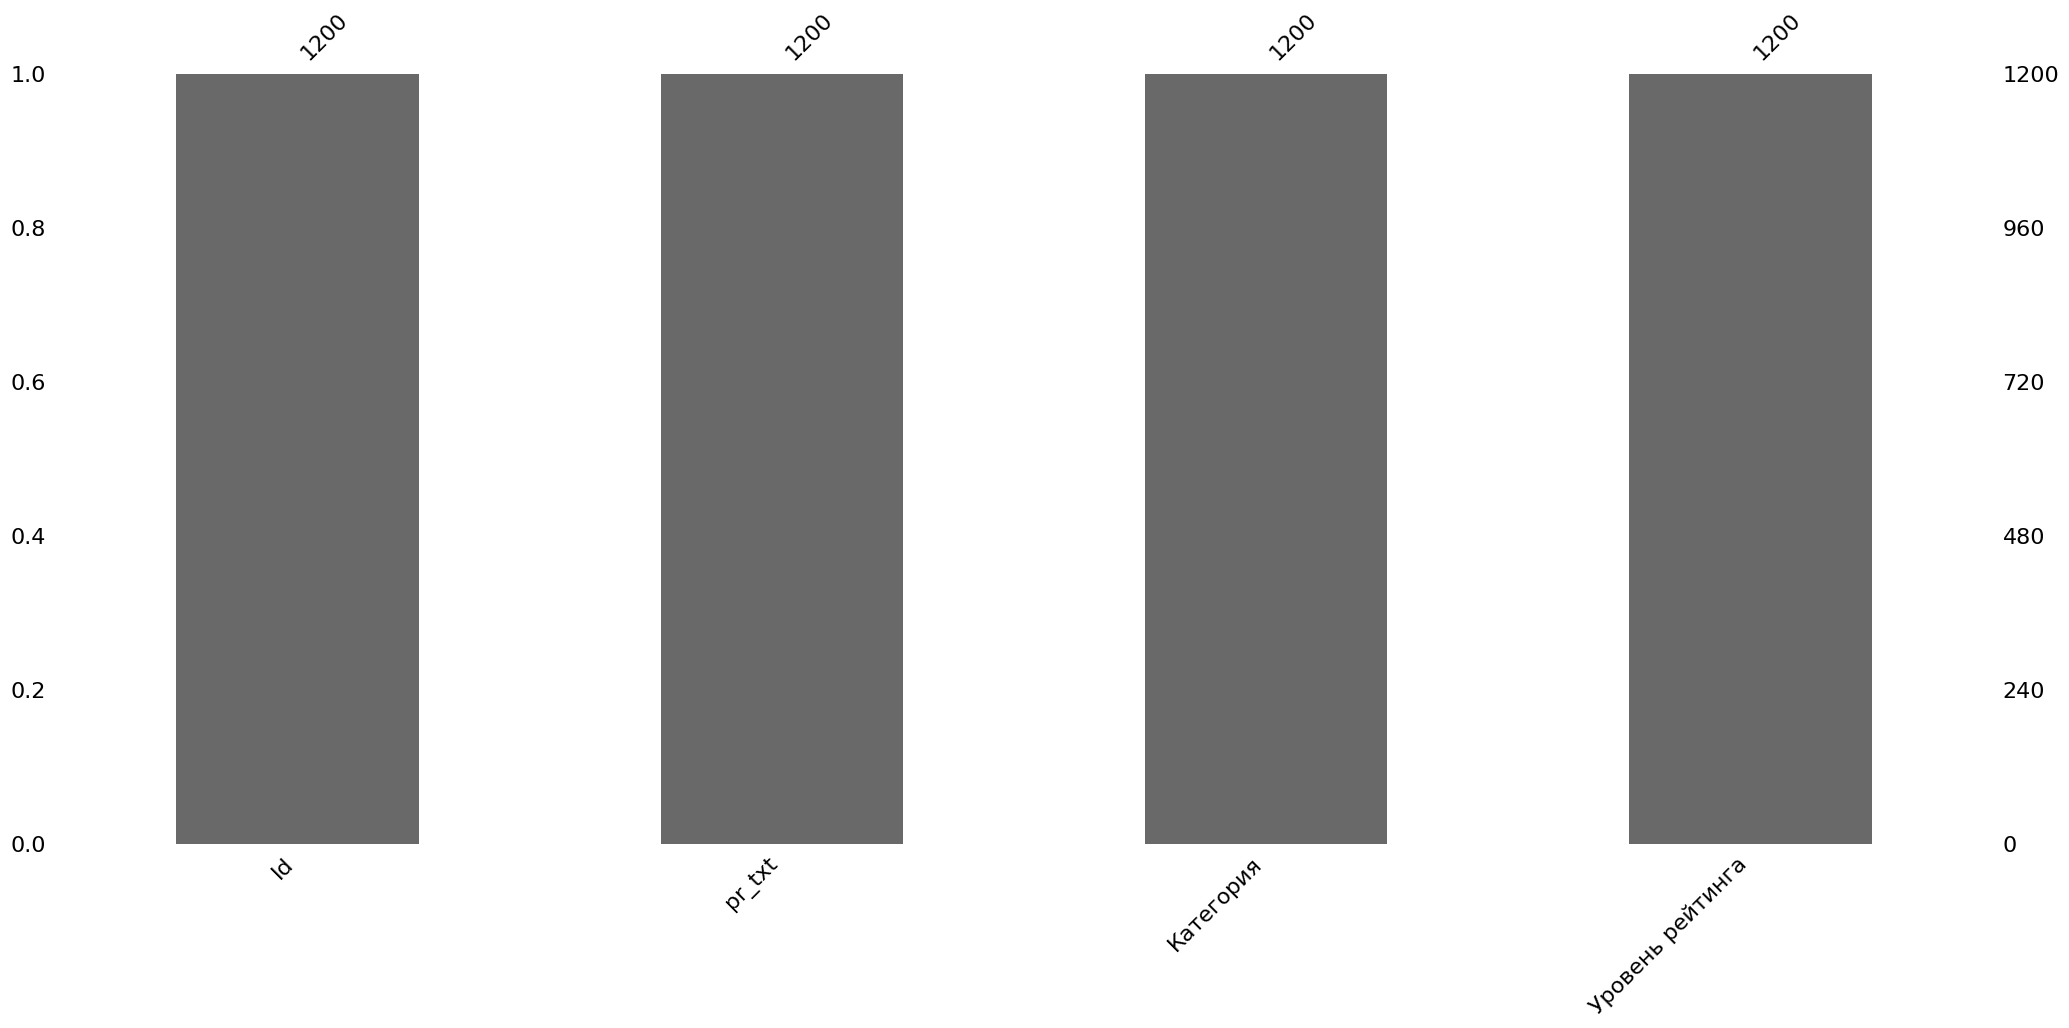

In [18]:
msno.bar(data)

## Text

In [19]:
data['len_text'] = data.pr_txt.apply(lambda x: len(x.split(' ')))
data['len_text']

0       1190
1       1182
2       1393
3       1825
4       1178
        ... 
1195    1229
1196    1296
1197    1175
1198    1281
1199    1633
Name: len_text, Length: 1200, dtype: int64

# Preprocess text

In [54]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

import pymorphy2
morph = pymorphy2.MorphAnalyzer()
import emoji

class Preprocess_text:
  @staticmethod
  def text_without_url(text):
    return re.sub(r'http\S+', '', text)

  @staticmethod
  def text_lowercase(text):
    # text = text_without_url(text)
    return text.lower()

  @staticmethod
  def remove_numbers(text):
    # text = text_lowercase(text)
    result = re.sub(r'\d+', '', text)
    return result

  @staticmethod
  def remove_punctuation(text):
    # text = remove_numbers(text)
    res = re.sub(r'[^\w\s]', '', text)
    return res

  @staticmethod
  def remove_whitespace(text):
    return  " ".join(text.split())

  @staticmethod
  def remove_emogi(text):
    # text = remove_whitespace(text)
    emoji_pattern = re.compile("["
          u"\U0001F600-\U0001F64F"  # emoticons
          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
          u"\U0001F680-\U0001F6FF"  # transport & map symbols
          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            "]+", flags=re.UNICODE)
    emoji_pattern = emoji_pattern.sub(r'', text)
    for elem in emoji_pattern:
      if emoji.is_emoji(elem) == True:
        emoji_pattern = emoji_pattern.replace(elem, '')
    return emoji_pattern

  @staticmethod
  def remove_stopwords(text):
    stop_words = set(stopwords.words("russian")+ stopwords.words('english')+['rating'])

    # filtered_text = [word for word in text if word not in stop_words] #after steming
    word_tokens = word_tokenize(text)  #after emogi
    filtered_text = [word for word in word_tokens if word not in stop_words] #after emogi
    return " ".join(filtered_text)

  @staticmethod
  def stem_words(text):
    stemmer = PorterStemmer()
    word_tokens = word_tokenize(text)
    stems = [stemmer.stem(word) for word in word_tokens]
    return stems

  @staticmethod
  def lemmatize_word(text):
    lemmatizer = WordNetLemmatizer()
    # provide context i.e. part-of-speech
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

  @staticmethod
  def inf_form(text):
    res = ''
    for i in text.split(' '):
        w = morph.parse(i)[0].normal_form
        res += str(w)
        res += ' '
    return res


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [67]:
data['text'] = data['pr_txt'].str.replace(r'\«(.*?)\»', '', regex=True)
data['text'] = data['text'].str.replace(r'\"(.*?)\"', '', regex=True)

data['text_lowercase'] = data.text.apply(lambda x: Preprocess_text.text_lowercase(x))
data['text_without_url'] = data.text_lowercase.apply(lambda x: Preprocess_text.text_without_url(x))
data['remove_numbers'] = data.text_without_url.apply(lambda x: Preprocess_text.remove_numbers(x))
data['remove_punctuation'] = data.remove_numbers.apply(lambda x: Preprocess_text.remove_punctuation(x))
data['remove_emogi'] = data.remove_punctuation.apply(lambda x: Preprocess_text.remove_emogi(x))
data['remove_whitespace'] = data.remove_emogi.apply(lambda x: Preprocess_text.remove_whitespace(x))
data['inf_form'] = data.remove_whitespace.apply(lambda x: Preprocess_text.inf_form(x))
data['remove_stopwords'] = data.inf_form.apply(lambda x: Preprocess_text.remove_stopwords(x))

In [45]:
# for col in data.columns:
#     print(col)
#     print(data[col][0])

In [70]:
data = data.drop(['text',
                  'text_lowercase',
                  'text_without_url',
                  'remove_numbers',
                  'remove_punctuation',
                  'remove_emogi',
                  'remove_whitespace',
                  'inf_form'], axis=1)


In [71]:
data

,Id,pr_txt,Категория,Уровень рейтинга,remove_stopwords
0,1,Повышение кредитного рейтинга Акционерного об...,A,A,повышение кредитный рейтинг акционерный общест...
1,2,«Эксперт РА» подтвердил кредитный рейтинг комп...,BB,BB,подтвердить кредитный рейтинг компания ооо уро...
2,3,"НКР повысило кредитный рейтинг ООО ""ОТЭКО-Порт...",A,A,нкр повысить кредитный рейтинг ооо стабильный ...
3,4,«Эксперт РА» присвоил кредитный рейтинг ПАО «Ф...,AAA,AAA,присвоить кредитный рейтинг пао уровень москва...
4,5,29 марта 2023 г. Ведущий рейтинговый аналитик ...,BBB,BBB,март г ведущий рейтинговый аналитик юров алла ...
...,...,...,...,...,...
1195,1207,«Эксперт РА» подтвердил рейтинг компании «Татн...,AAA,AAA,подтвердить рейтинг компания уровень москва ап...
1196,1208,«Эксперт РА» понизил рейтинг компании «Инвестг...,BB,BB,понизить рейтинг компания уровень изменить про...
1197,1209,АКРА подтвердило ПАО «КАМАЗ» кредитный рейтинг...,A,A+,акр подтвердить пао кредитный рейтинг прогноз ...
1198,1210,АКРА подтвердило кредитный рейтинг ФГУП «Почта...,AAA,AAA,акр подтвердить кредитный рейтинг фгуп уровень...


In [72]:
data.to_excel('/content/drive/My Drive/hacks/hack_nizh/prep_data.xlsx')

# Выделение цифр из текста

In [26]:
data = pd.read_excel('/content/drive/My Drive/hacks/hack_nizh/prep_data.xlsx')

In [13]:
data['remove_punctuation'] = data.pr_txt.apply(lambda x: Preprocess_text.remove_punctuation(x))

In [14]:
word_list = data['remove_punctuation'][0].split()

In [51]:
num_list = {}
w_zero = {}
w_first = {}
w_second = {}
w_third = {}
for i in range(len(word_list)):
    if i == 0 and word_list[i].isnumeric():
        w_zero[i] = '-'
        w_first[i] = '-'
        w_second[i] = word_list[i+1]
        w_third[i] = word_list[i+2]
    elif i == 1 and word_list[i].isnumeric():
        w_zero[i] = '-'
        w_first[i] = word_list[i-1]
        w_second[i] = word_list[i+1]
        w_third[i] = word_list[i+2]
    elif i == (len(word_list)-1) and word_list[i].isnumeric():
        w_zero[i] = word_list[i-2]
        w_first[i] = word_list[i-1]
        w_second[i] = '-'
        w_third[i] = '-'
    elif (i!=0) and (i!=(len(word_list)-1)) and (word_list[i].isnumeric()):
        num_list[i] = (int(word_list[i]))
        w_zero[i] = word_list[i-2]
        w_first[i] = word_list[i-1]
        w_second[i] = word_list[i+1]
        w_third[i] = word_list[i+2]

In [52]:
for k, i, n, j, g in zip(w_zero, w_first, num_list, w_second, w_third):
    print(w_zero[k], w_first[i], num_list[n], w_second[j], w_third[g])
    print('///////////////////////////////')

погашением в 2025 году Также
///////////////////////////////
доменной печи 3 находившейся ранее
///////////////////////////////
Компании в 2023 году Кредитный
///////////////////////////////
В начале 2022 года Акционерное
///////////////////////////////
ЗТЗ приобрело 100 уставного капитала
///////////////////////////////
формирует до 50 консолидированной выручки
///////////////////////////////
налогов за 2022 год составила
///////////////////////////////
год составила 12 и ожидается
///////////////////////////////
уровне около 18 в 2023м
///////////////////////////////
по результатам 2022 года и
///////////////////////////////
по результатам 2023 года средней
///////////////////////////////
налогов менее 30 млрд руб
///////////////////////////////
В декабре 2022 года Компания
///////////////////////////////
погашением в 2025 году АКРА
///////////////////////////////
по результатам 2023 года Высокая
///////////////////////////////
на горизонте 1218 месяцев К
////////////////////////////

In [54]:
from transformers import pipeline
p = pipeline(
  task='zero-shot-classification',
  model='cointegrated/rubert-base-cased-nli-twoway'
)


In [56]:
p(
  sequences="объем эмиссии 10 млрд руб",
  candidate_labels="Мне понравилось, Мне не понравилось",
  hypothesis_template="{}.")

{'sequence': 'объем эмиссии 10 млрд руб',
 'labels': ['Мне понравилось', 'Мне не понравилось'],
 'scores': [0.6100800037384033, 0.3899199664592743]}

In [57]:
p(
  sequences="срок погашения 25122025 объем эмиссии",
  candidate_labels="Мне понравилось, Мне не понравилось",
  hypothesis_template="{}.")

{'sequence': 'срок погашения 25122025 объем эмиссии',
 'labels': ['Мне понравилось', 'Мне не понравилось'],
 'scores': [0.6378627419471741, 0.3621372580528259]}

In [58]:
p(
  sequences="налогов выше 30 млрд руб",
  candidate_labels="Мне понравилось, Мне не понравилось",
  hypothesis_template="{}.")

{'sequence': 'налогов выше 30 млрд руб',
 'labels': ['Мне понравилось', 'Мне не понравилось'],
 'scores': [0.5279799103736877, 0.4720200300216675]}

# Наиболее часто встречающиеся слова

In [73]:
text_all = ''
for i in data['remove_stopwords']:
    text_all += i

In [74]:
from nltk import word_tokenize
import nltk
from nltk.probability import FreqDist

In [75]:
# text = data['remove_stopwords'][0]
text = text_all
# токенизируем текст
text_tokens = word_tokenize(text)
# переводим токены в текстовый формат
text = nltk.Text(text_tokens)
# и считаем слова в тексте по популярности
fdist = FreqDist(text)
# выводим первые 5 популярных слов
print(fdist.most_common(100))

[('рейтинг', 21317), ('компания', 14913), ('ао', 12735), ('кредитный', 12620), ('год', 10291), ('рейтинговый', 8913), ('уровень', 7431), ('являться', 7268), ('информация', 5987), ('также', 5196), ('оценка', 5038), ('высокий', 4855), ('прогноз', 4752), ('агентство', 4212), ('ооо', 4193), ('мнение', 4166), ('долг', 4072), ('финансовый', 3918), ('акр', 3888), ('платёж', 3848), ('который', 3768), ('комитет', 3464), ('процентный', 3460), ('руб', 3399), ('присвоение', 3311), ('присвоить', 3234), ('группа', 3228), ('пао', 3223), ('показатель', 3132), ('млрд', 3114), ('представить', 3069), ('рамка', 2952), ('объём', 2880), ('иной', 2835), ('ffo', 2807), ('лицо', 2783), ('отношение', 2768), ('обязательство', 2680), ('рост', 2676), ('чистый', 2655), ('весь', 2644), ('рентабельность', 2589), ('методология', 2521), ('источник', 2457), ('фактор', 2456), ('х', 2456), ('оказывать', 2409), ('действие', 2350), ('ключевой', 2304), ('качество', 2221), ('отражать', 2197), ('выручка', 2189), ('рынок', 2176

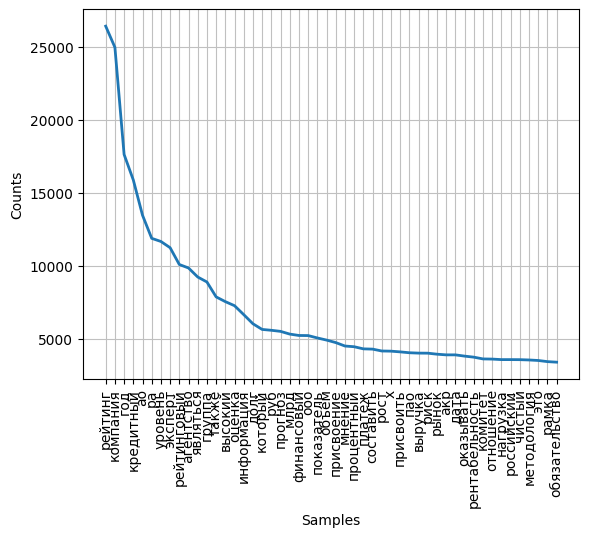

<Axes: xlabel='Samples', ylabel='Counts'>

In [33]:
fdist.plot(50,cumulative=False)

In [76]:
# fdist

In [77]:
frec = pd.DataFrame(fdist.items(), columns=['word', 'frequency'])

In [78]:
frec

,word,frequency
0,повышение,501
1,кредитный,12620
2,рейтинг,21317
3,акционерный,575
4,общество,497
...,...,...
8718,predix,1
8719,clouddc,1
8720,всплеск,1
8721,аналитически,1


In [4]:
# frec.to_excel('/content/drive/My Drive/hacks/hack_nizh/frec.xlsx')
frec = pd.read_excel('/content/drive/My Drive/hacks/hack_nizh/frec.xlsx')

In [80]:
# print(fdist.most_common(5000))

A


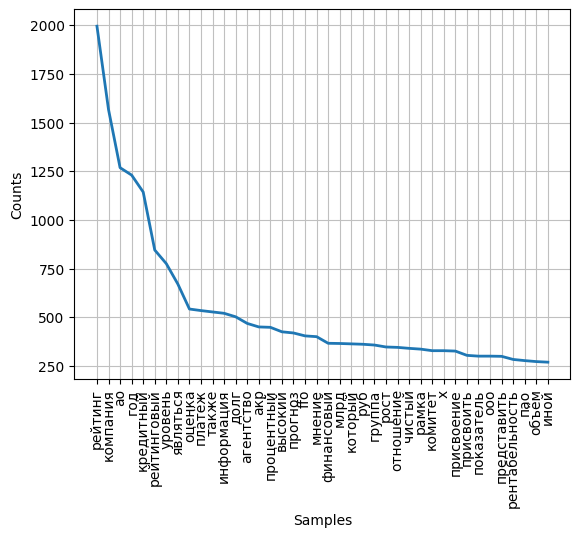

BB


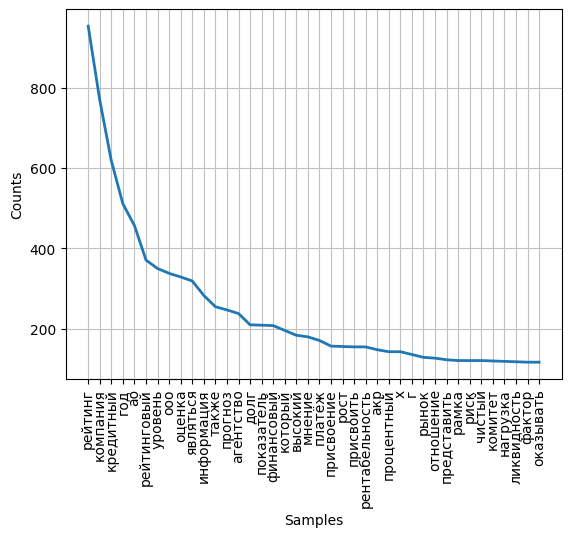

AAA


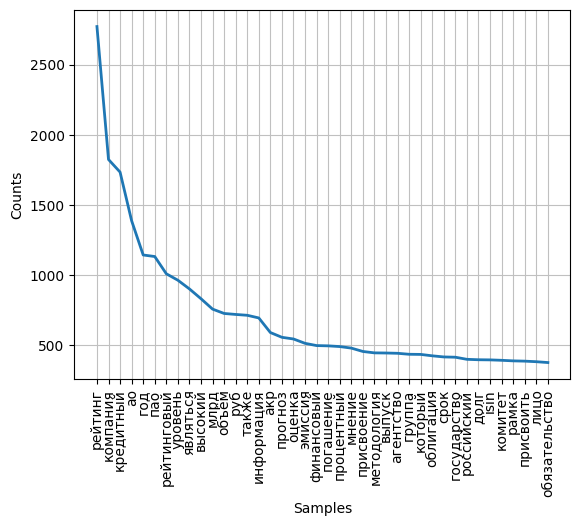

BBB


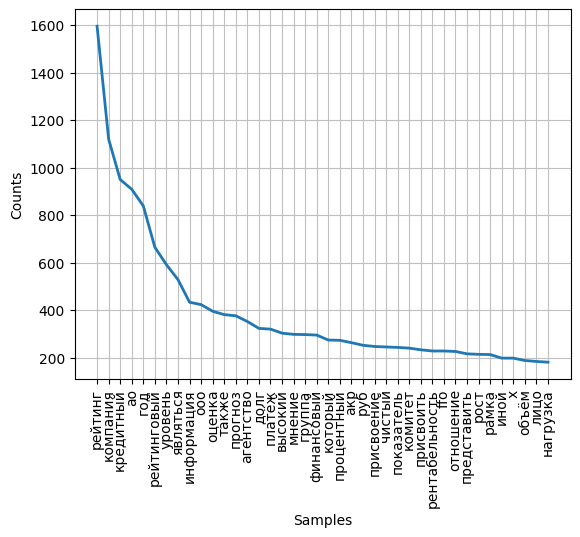

AA+


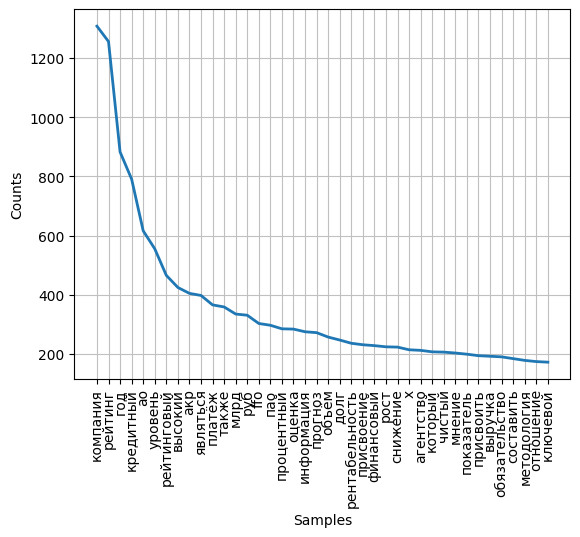

BB+


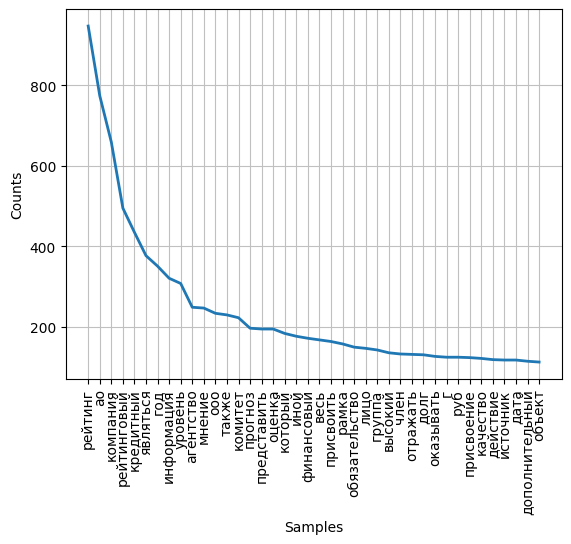

BB-


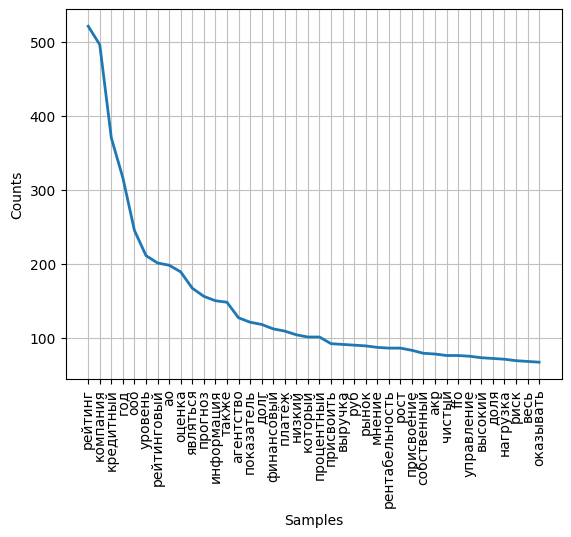

A-


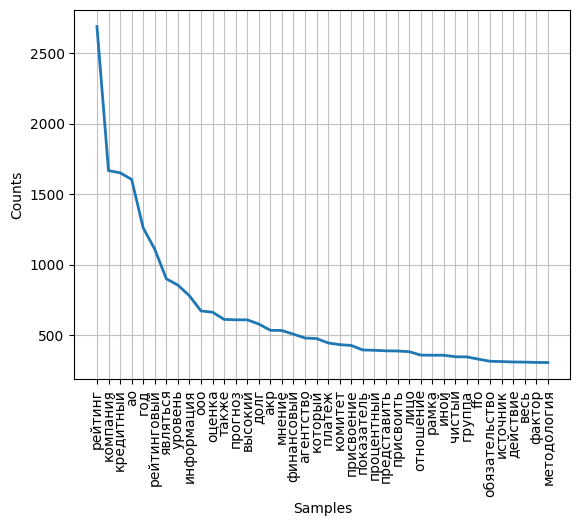

A+


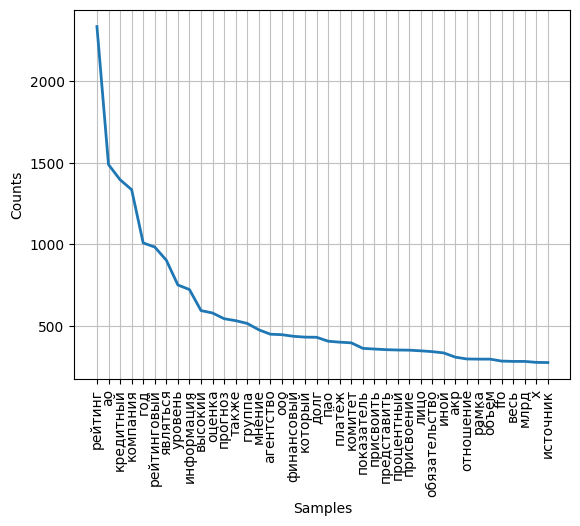

B


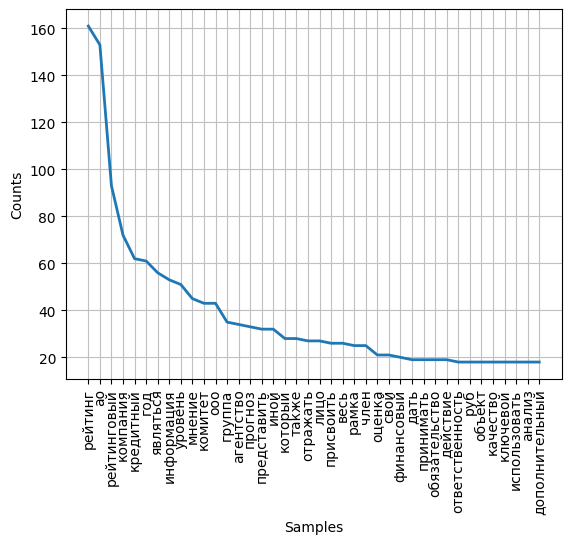

AA-


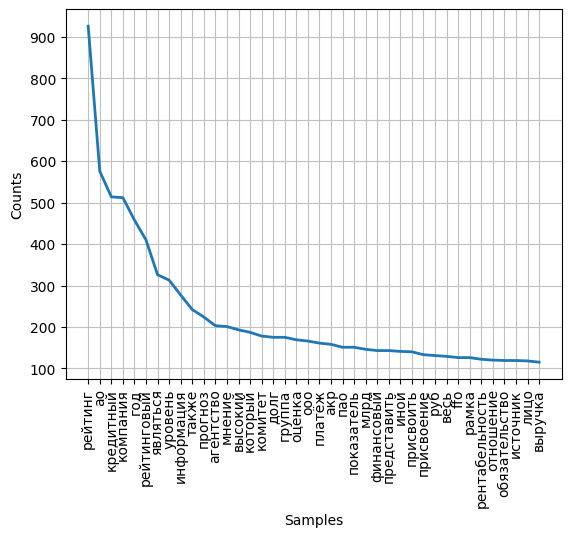

BBB+


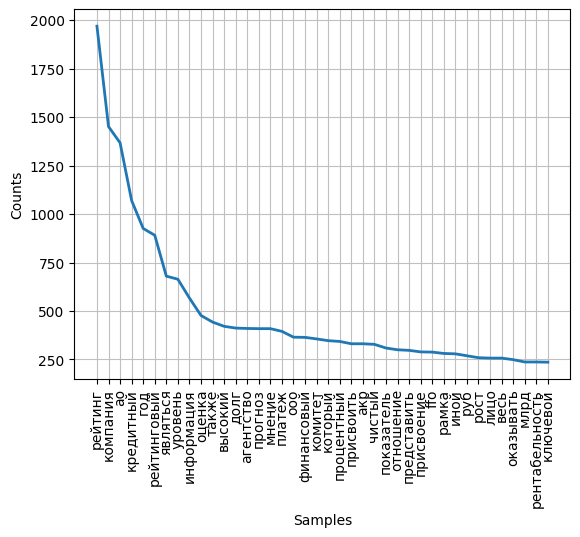

BBB-


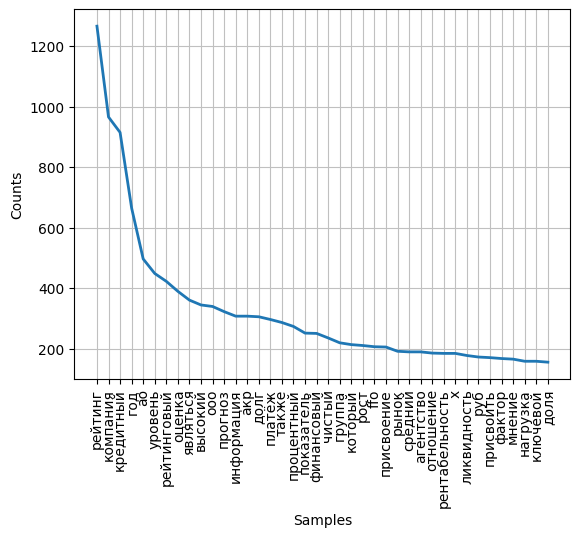

B-


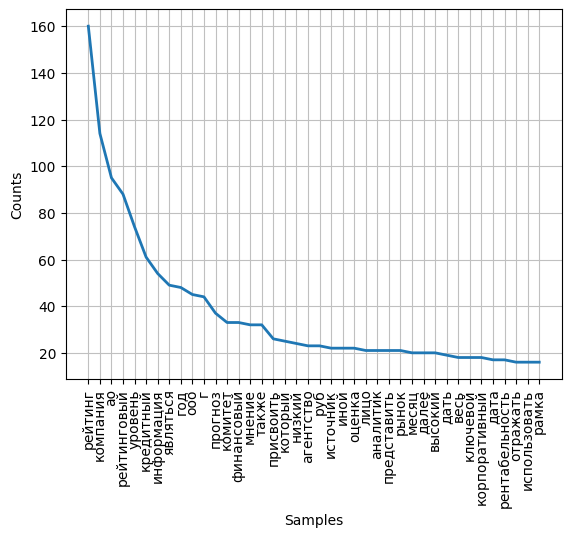

AA


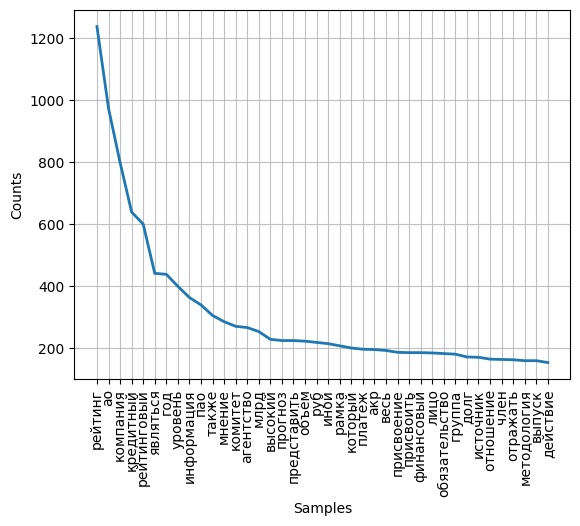

B+


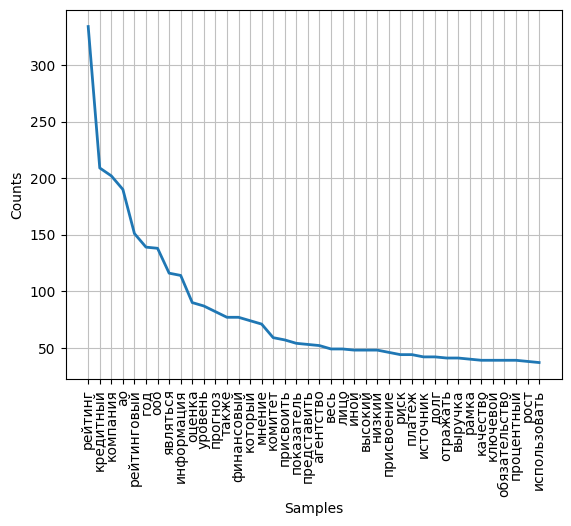

C


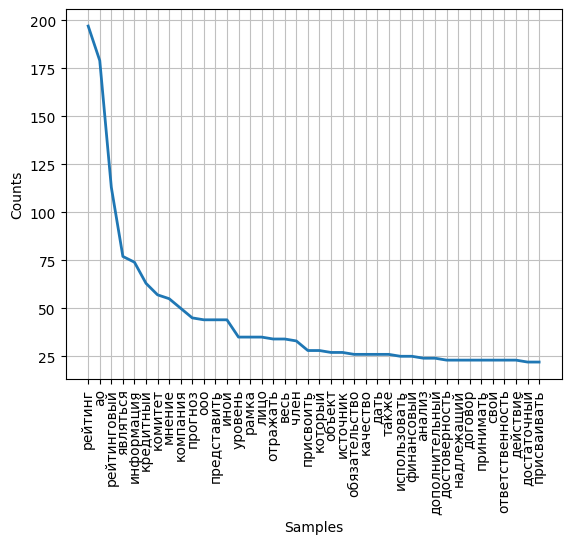

In [83]:
top_list = []
for rate in data['Уровень рейтинга'].unique():
    print(rate)
    text_all = ''
    for i in data[data['Уровень рейтинга'] == rate].remove_stopwords:
        text_all += i

    text_tokens = word_tokenize(text_all)
    text_all = nltk.Text(text_tokens)
    fdist = FreqDist(text_all)
    #top 40 words
    # print(fdist.most_common(40))
    top_list.append(fdist.most_common(50))
    fdist.plot(40,cumulative=False)

In [84]:
for i in range(len(top_list)):
    for w in range(len(top_list[i])):
        top_list[i][w] = top_list[i][w][0]

In [88]:
for i in range(len(top_list)):
    try:
        top_list[i].remove('рейтинг')
    except:
        Exception

    try:
        top_list[i].remove('год')
    except:
        Exception

    try:
        top_list[i].remove('компания')
    except:
        Exception

    try:
        top_list[i].remove('кредитный')
    except:
        Exception

    try:
        top_list[i].remove('х')
    except:
        Exception

    try:
        top_list[i].remove('г')
    except:
        Exception

    try:
        top_list[i].remove('также')
    except:
        Exception

    try:
        top_list[i].remove('руб')
    except:
        Exception



In [90]:
def word_rate0(x, n_rate):
    num_rate = 0
    for i in x.split(' '):
        if i in top_list[n_rate]:
            num_rate += 1
    return num_rate



In [91]:
data['top_w_rate0'] = data.remove_stopwords.apply(lambda x: word_rate0(x, 0))
data['top_w_rate1'] = data.remove_stopwords.apply(lambda x: word_rate0(x, 1))
data['top_w_rate2'] = data.remove_stopwords.apply(lambda x: word_rate0(x, 2))
data['top_w_rate3'] = data.remove_stopwords.apply(lambda x: word_rate0(x, 3))
data['top_w_rate4'] = data.remove_stopwords.apply(lambda x: word_rate0(x, 4))
data['top_w_rate5'] = data.remove_stopwords.apply(lambda x: word_rate0(x, 5))
data['top_w_rate6'] = data.remove_stopwords.apply(lambda x: word_rate0(x, 6))
data['top_w_rate7'] = data.remove_stopwords.apply(lambda x: word_rate0(x, 7))
data['top_w_rate8'] = data.remove_stopwords.apply(lambda x: word_rate0(x, 8))
data['top_w_rate9'] = data.remove_stopwords.apply(lambda x: word_rate0(x, 9))
data['top_w_rate10'] = data.remove_stopwords.apply(lambda x: word_rate0(x, 10))
data['top_w_rate11'] = data.remove_stopwords.apply(lambda x: word_rate0(x, 11))
data['top_w_rate12'] = data.remove_stopwords.apply(lambda x: word_rate0(x, 12))
data['top_w_rate13'] = data.remove_stopwords.apply(lambda x: word_rate0(x, 13))
data['top_w_rate14'] = data.remove_stopwords.apply(lambda x: word_rate0(x, 14))
data['top_w_rate15'] = data.remove_stopwords.apply(lambda x: word_rate0(x, 15))
data['top_w_rate16'] = data.remove_stopwords.apply(lambda x: word_rate0(x, 16))


In [92]:
data

,Id,pr_txt,Категория,Уровень рейтинга,remove_stopwords,top_w_rate0,top_w_rate1,top_w_rate2,top_w_rate3,top_w_rate4,...,top_w_rate7,top_w_rate8,top_w_rate9,top_w_rate10,top_w_rate11,top_w_rate12,top_w_rate13,top_w_rate14,top_w_rate15,top_w_rate16
0,1,Повышение кредитного рейтинга Акционерного об...,A,A,повышение кредитный рейтинг акционерный общест...,170,175,156,173,188,...,171,161,87,162,171,198,121,151,146,64
1,2,«Эксперт РА» подтвердил кредитный рейтинг комп...,BB,BB,подтвердить кредитный рейтинг компания ооо уро...,89,83,81,90,70,...,96,95,122,96,96,70,106,99,101,133
2,3,"НКР повысило кредитный рейтинг ООО ""ОТЭКО-Порт...",A,A,нкр повысить кредитный рейтинг ооо стабильный ...,206,210,160,212,185,...,204,203,156,198,203,213,192,161,224,154
3,4,«Эксперт РА» присвоил кредитный рейтинг ПАО «Ф...,AAA,AAA,присвоить кредитный рейтинг пао уровень москва...,91,80,88,87,77,...,93,97,119,98,93,67,103,106,98,130
4,5,29 марта 2023 г. Ведущий рейтинговый аналитик ...,BBB,BBB,март г ведущий рейтинговый аналитик юров алла ...,34,37,28,34,34,...,34,33,26,35,33,37,48,30,34,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1207,«Эксперт РА» подтвердил рейтинг компании «Татн...,AAA,AAA,подтвердить рейтинг компания уровень москва ап...,182,166,174,178,176,...,177,187,185,182,159,164,167,199,160,173
1196,1208,«Эксперт РА» понизил рейтинг компании «Инвестг...,BB,BB,понизить рейтинг компания уровень изменить про...,184,175,165,192,193,...,181,183,179,190,188,175,194,205,187,184
1197,1209,АКРА подтвердило ПАО «КАМАЗ» кредитный рейтинг...,A,A+,акр подтвердить пао кредитный рейтинг прогноз ...,183,147,227,166,203,...,156,180,64,166,165,189,92,168,130,54
1198,1210,АКРА подтвердило кредитный рейтинг ФГУП «Почта...,AAA,AAA,акр подтвердить кредитный рейтинг фгуп уровень...,149,132,182,141,153,...,141,139,82,134,148,159,111,142,132,74


In [93]:
data.to_excel('/content/drive/My Drive/hacks/hack_nizh/data_w_rate.xlsx')

# Сделаем фичи, означающие наличие позитивных или негативных слов

In [94]:
positive = ['высокий',
            "рост",
            "выручка", "рентабельность", "чистый",
            "ликвидность", "ffo", "ebitda"]

negative = ['долг', "риск", "снижение", "низкий"]

In [95]:
frec_razm = pd.read_excel('/content/drive/My Drive/hacks/hack_nizh/frec_razm.xlsx')

положительные слова

In [96]:
for w in frec_razm[frec_razm['Unnamed: 3'] == 1].word:
    positive.append(w)

In [97]:
len(positive)

46

In [98]:
positive

['высокий',
 'рост',
 'выручка',
 'рентабельность',
 'чистый',
 'ликвидность',
 'ffo',
 'ebitda',
 'позитивный',
 'кредитоспособность',
 'погашение',
 'сильный',
 'долгосрочный',
 'эмиссия',
 'увеличение',
 'мсфо',
 'положительный',
 'умеренный',
 'положительно',
 'улучшение',
 'доход',
 'инвестиция',
 'дивиденд',
 'дочерний',
 'мировой',
 'привлечение',
 'сделка',
 'комфортный',
 'хороший',
 'качественный',
 'диверсифицировать',
 'oibda',
 'получение',
 'доступный',
 'поступление',
 'высоко',
 'успешный',
 'снизить',
 'развивающийся',
 'благоприятный',
 'прирост',
 'согласовать',
 'наращивать',
 'укрепление',
 'рефинансировать',
 'стабилизация']

негативные слова

In [99]:
for w in frec_razm[frec_razm['Unnamed: 3'] == 0].word:
    negative.append(w)

In [100]:
len(negative)

36

In [101]:
negative

['долг',
 'риск',
 'снижение',
 'низкий',
 'долгов',
 'долговой',
 'продажа',
 'негативный',
 'налог',
 'последствие',
 'краткосрочный',
 'риска',
 'превышать',
 'ухудшение',
 'задолженность',
 'сокращение',
 'падение',
 'необеспеченный',
 'слабый',
 'запретить',
 'убыток',
 'превысить',
 'потеря',
 'издержка',
 'просрочить',
 'неопределённость',
 'износ',
 'несубординировать',
 'нарушение',
 'загрузка',
 'ослабление',
 'дефолт',
 'дефицит',
 'санкция',
 'превышение',
 'недостаток']

In [102]:
data.head()

,Id,pr_txt,Категория,Уровень рейтинга,remove_stopwords,top_w_rate0,top_w_rate1,top_w_rate2,top_w_rate3,top_w_rate4,...,top_w_rate7,top_w_rate8,top_w_rate9,top_w_rate10,top_w_rate11,top_w_rate12,top_w_rate13,top_w_rate14,top_w_rate15,top_w_rate16
0,1,Повышение кредитного рейтинга Акционерного об...,A,A,повышение кредитный рейтинг акционерный общест...,170,175,156,173,188,...,171,161,87,162,171,198,121,151,146,64
1,2,«Эксперт РА» подтвердил кредитный рейтинг комп...,BB,BB,подтвердить кредитный рейтинг компания ооо уро...,89,83,81,90,70,...,96,95,122,96,96,70,106,99,101,133
2,3,"НКР повысило кредитный рейтинг ООО ""ОТЭКО-Порт...",A,A,нкр повысить кредитный рейтинг ооо стабильный ...,206,210,160,212,185,...,204,203,156,198,203,213,192,161,224,154
3,4,«Эксперт РА» присвоил кредитный рейтинг ПАО «Ф...,AAA,AAA,присвоить кредитный рейтинг пао уровень москва...,91,80,88,87,77,...,93,97,119,98,93,67,103,106,98,130
4,5,29 марта 2023 г. Ведущий рейтинговый аналитик ...,BBB,BBB,март г ведущий рейтинговый аналитик юров алла ...,34,37,28,34,34,...,34,33,26,35,33,37,48,30,34,25


In [106]:
def negative_rate(x):
    neg_rate = 0
    for i in x.split(' '):
        if i in negative:
            neg_rate += 1
    return neg_rate

def positive_rate(x):
    pos_rate = 0
    for i in x.split(' '):
        if i in positive:
            pos_rate += 1
    return pos_rate

In [107]:
data['positive'] = data.remove_stopwords.apply(lambda x: positive_rate(x))
data['negative'] = data.remove_stopwords.apply(lambda x: negative_rate(x))

In [108]:
data.positive.max()

164

In [109]:
data.negative.max()

72

In [110]:
data.positive.min()

1

In [111]:
data.negative.min()

1

In [112]:
data.head(10)

,Id,pr_txt,Категория,Уровень рейтинга,remove_stopwords,top_w_rate0,top_w_rate1,top_w_rate2,top_w_rate3,top_w_rate4,...,top_w_rate9,top_w_rate10,top_w_rate11,top_w_rate12,top_w_rate13,top_w_rate14,top_w_rate15,top_w_rate16,positive,negative
0,1,Повышение кредитного рейтинга Акционерного об...,A,A,повышение кредитный рейтинг акционерный общест...,170,175,156,173,188,...,87,162,171,198,121,151,146,64,69,32
1,2,«Эксперт РА» подтвердил кредитный рейтинг комп...,BB,BB,подтвердить кредитный рейтинг компания ооо уро...,89,83,81,90,70,...,122,96,96,70,106,99,101,133,1,2
2,3,"НКР повысило кредитный рейтинг ООО ""ОТЭКО-Порт...",A,A,нкр повысить кредитный рейтинг ооо стабильный ...,206,210,160,212,185,...,156,198,203,213,192,161,224,154,63,42
3,4,«Эксперт РА» присвоил кредитный рейтинг ПАО «Ф...,AAA,AAA,присвоить кредитный рейтинг пао уровень москва...,91,80,88,87,77,...,119,98,93,67,103,106,98,130,1,2
4,5,29 марта 2023 г. Ведущий рейтинговый аналитик ...,BBB,BBB,март г ведущий рейтинговый аналитик юров алла ...,34,37,28,34,34,...,26,35,33,37,48,30,34,25,10,3
5,6,Кредитный рейтинг ПАО «ФосАгро» (далее — Комп...,AAA,AAA,кредитный рейтинг пао далее компания группа об...,135,135,119,129,147,...,69,127,128,139,90,116,116,51,48,17
6,7,«Эксперт РА» повысил кредитный рейтинг ОАО «МР...,AA,AA+,повысить кредитный рейтинг оао уровень москва ...,86,80,83,87,72,...,119,93,93,67,103,101,98,130,1,2
7,8,«Эксперт РА» понизил кредитный рейтинг ПАО «М....,A,A,понизить кредитный рейтинг пао уровень изменит...,91,80,88,87,77,...,119,98,93,67,103,106,98,130,3,2
8,9,«Эксперт РА» повысил кредитный рейтинг компани...,BB,BB+,повысить кредитный рейтинг компания ооо уровен...,92,86,84,93,73,...,125,99,99,73,109,102,104,136,3,2
9,10,Кредитный рейтинг ООО «МВМ» (далее — Компани...,A,A,кредитный рейтинг ооо далее компания мвм обусл...,116,107,135,109,97,...,99,110,101,126,99,109,89,80,14,11


In [83]:
# data = data.drop('Unnamed: 0', axis=1)

# Самые частые удаляем

In [5]:
frec = frec.sort_values('frequency', ascending=False)

In [6]:
frec

,Unnamed: 0,word,frequency
2,2,рейтинг,21317
6,6,компания,14913
86,86,ао,12735
1,1,кредитный,12620
22,22,год,10291
...,...,...,...
2588,2588,волгоградский,1
6994,6994,авиатор,1
6995,6995,макрорегиональный,1
6996,6996,мрф,1


In [7]:
top_50 = list(frec.word[:50])

In [8]:
top_50

['рейтинг',
 'компания',
 'ао',
 'кредитный',
 'год',
 'рейтинговый',
 'уровень',
 'являться',
 'информация',
 'также',
 'оценка',
 'высокий',
 'прогноз',
 'агентство',
 'ооо',
 'мнение',
 'долг',
 'финансовый',
 'акр',
 'платёж',
 'который',
 'комитет',
 'процентный',
 'руб',
 'присвоение',
 'присвоить',
 'группа',
 'пао',
 'показатель',
 'млрд',
 'представить',
 'рамка',
 'объём',
 'иной',
 'ffo',
 'лицо',
 'отношение',
 'обязательство',
 'рост',
 'чистый',
 'весь',
 'рентабельность',
 'методология',
 'источник',
 'х',
 'фактор',
 'оказывать',
 'действие',
 'ключевой',
 'качество']

In [133]:
pat = r'\b(?:{})\b'.format('|'.join(top_50))
data['text'] = data['remove_stopwords'].str.replace(pat, '', regex=True)

In [134]:
data

,Id,pr_txt,Категория,Уровень рейтинга,remove_stopwords,top_w_rate0,top_w_rate1,top_w_rate2,top_w_rate3,top_w_rate4,...,top_w_rate10,top_w_rate11,top_w_rate12,top_w_rate13,top_w_rate14,top_w_rate15,top_w_rate16,positive,negative,text
0,1,Повышение кредитного рейтинга Акционерного об...,A,A,повышение кредитный рейтинг акционерный общест...,170,175,156,173,188,...,162,171,198,121,151,146,64,69,32,повышение акционерный общество далее вызват...
1,2,«Эксперт РА» подтвердил кредитный рейтинг комп...,BB,BB,подтвердить кредитный рейтинг компания ооо уро...,89,83,81,90,70,...,96,96,70,106,99,101,133,1,2,подтвердить ооо москва март г агентство п...
2,3,"НКР повысило кредитный рейтинг ООО ""ОТЭКО-Порт...",A,A,нкр повысить кредитный рейтинг ооо стабильный ...,206,210,160,212,185,...,198,203,213,192,161,224,154,63,42,нкр повысить ооо стабильный прогноз март ст...
3,4,«Эксперт РА» присвоил кредитный рейтинг ПАО «Ф...,AAA,AAA,присвоить кредитный рейтинг пао уровень москва...,91,80,88,87,77,...,98,93,67,103,106,98,130,1,2,присвоить пао москва март г агентство прис...
4,5,29 марта 2023 г. Ведущий рейтинговый аналитик ...,BBB,BBB,март г ведущий рейтинговый аналитик юров алла ...,34,37,28,34,34,...,35,33,37,48,30,34,25,10,3,март г ведущий аналитик юров алла младший дир...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1207,«Эксперт РА» подтвердил рейтинг компании «Татн...,AAA,AAA,подтвердить рейтинг компания уровень москва ап...,182,166,174,178,176,...,182,159,164,167,199,160,173,31,13,подтвердить москва апрель г агентство подт...
1196,1208,«Эксперт РА» понизил рейтинг компании «Инвестг...,BB,BB,понизить рейтинг компания уровень изменить про...,184,175,165,192,193,...,190,188,175,194,205,187,184,37,27,понизить изменить прогноз развивающийся уст...
1197,1209,АКРА подтвердило ПАО «КАМАЗ» кредитный рейтинг...,A,A+,акр подтвердить пао кредитный рейтинг прогноз ...,183,147,227,166,203,...,166,165,189,92,168,130,54,56,31,акр подтвердить пао прогноз подтвердить обл...
1198,1210,АКРА подтвердило кредитный рейтинг ФГУП «Почта...,AAA,AAA,акр подтвердить кредитный рейтинг фгуп уровень...,149,132,182,141,153,...,134,148,159,111,142,132,74,49,22,акр подтвердить фгуп прогноз облигация ...


In [135]:
data.to_excel('/content/drive/My Drive/hacks/hack_nizh/data_w_top10.xlsx')

In [ ]:
dict_to_save = {'top_50':top_50,
                'negative':negative,
                'positive':positive,
                'top_list ':top_list}

In [ ]:
df_tosave = pd.DataFrame(dict_to_save)